## XGBoost Model

This notebook consist of the following aspects:

### 1. Running the XGBoost model - w Grid Search
- Performance evaluation on Validation Set
### 2. Performance Evaluation on Validation Set
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
### 3. Feature Importance Analysis
### 4. SHAP Analysis
- Global impact of features (summary bar + beeswarm plots)
- Feature effects on individual predictions
### 5. CV with Train and Validation & Learning Curve
### 6. Threshold Tuning & Metrics
- ROC Curve & AUC
- Precision-Recall Curve
- Class-wise performance (Classification Report)
- Optimal classification threshold using F1 score (worth exploring)
### 7. Error Analysis (extra)
Analysis on:
- False Positives: Model predicted 1, actual 0
- False Negatives: Model predicted 0, actual 1
(Also included a SHAP analysis on the subset - to understand why are they wrong)


## 1 & 2 - Model and Performance Evaluation

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the respective datasets
train_data = pd.read_csv(r'/Users/shamalan/Documents/Projects/SEM-2/Data Mining/Project/UMA_IE500_Data_Mining/[3] full dataset preparation and baseline model evaluation/train_data.csv')
val_data = pd.read_csv(r'/Users/shamalan/Documents/Projects/SEM-2/Data Mining/Project/UMA_IE500_Data_Mining/[3] full dataset preparation and baseline model evaluation/val_data.csv')

X_train = train_data.drop(columns=['is_canceled'])
y_train = train_data['is_canceled']

X_val = val_data.drop(columns=['is_canceled'])
y_val = val_data['is_canceled']

# Grid Search
results = []
best_recall = 0
best_model = None
best_params = None

for n_estimators in [64, 80, 96]:
    for subsample in [1.0, 0.8]:
        for learning_rate in [0.1, 0.2, 0.05]:
            for max_depth in [3, 6, 9]:

                print(f"Training with: n_estimators={n_estimators}, max_depth={max_depth}, "
                      f"learning_rate={learning_rate}, subsample={subsample}")

                model = xgb.XGBClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    subsample=subsample,
                    random_state=42,
                    eval_metric='logloss',
                    tree_method='auto'  # Use 'gpu_hist' if GPU is available
                )

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                acc = accuracy_score(y_val, y_pred)
                prec = precision_score(y_val, y_pred)
                rec = recall_score(y_val, y_pred)
                f1 = f1_score(y_val, y_pred)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    'f1_score': f1
                })

                if rec > best_recall:
                    best_recall = rec
                    best_model = model
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                print(f"Recall: {rec:.4f}\n" + "-" * 50)

#Best Model
print("\nBest Recall on Validation:", best_recall)
print("Best Hyperparameters:", best_params)

#METRICS
y_val_pred = best_model.predict(X_val)

print("\nEvaluation on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Training with: n_estimators=64, max_depth=3, learning_rate=0.1, subsample=1.0
Recall: 0.7439
--------------------------------------------------
Training with: n_estimators=64, max_depth=6, learning_rate=0.1, subsample=1.0
Recall: 0.7779
--------------------------------------------------
Training with: n_estimators=64, max_depth=9, learning_rate=0.1, subsample=1.0
Recall: 0.8049
--------------------------------------------------
Training with: n_estimators=64, max_depth=3, learning_rate=0.2, subsample=1.0
Recall: 0.7721
--------------------------------------------------
Training with: n_estimators=64, max_depth=6, learning_rate=0.2, subsample=1.0
Recall: 0.8056
--------------------------------------------------
Training with: n_estimators=64, max_depth=9, learning_rate=0.2, subsample=1.0
Recall: 0.8240
--------------------------------------------------
Training with: n_estimators=64, max_depth=3, learning_rate=0.05, subsample=1.0
Recall: 0.5925
------------------------------------------

In [25]:
# # Randomized Search
# param_grid = {
#     'n_estimators': [64, 80, 96],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.2, 0.05],
#     'subsample': [1.0, 0.8]
# }

# # Generate all combinations
# param_combinations = [
#     {'n_estimators': ne, 'max_depth': md, 'learning_rate': lr, 'subsample': ss}
#     for ne in param_grid['n_estimators']
#     for md in param_grid['max_depth']
#     for lr in param_grid['learning_rate']
#     for ss in param_grid['subsample']
# ]

# # Random sampling
# random.seed(42)
# random.shuffle(param_combinations)
# param_combinations = param_combinations[:10]  # Test only 10 random combinations

# results = []
# best_recall = 0
# best_model = None
# best_params = None

# for params in param_combinations:
#     print(f"Training with: {params}")

#     model = xgb.XGBClassifier(
#         n_estimators=params['n_estimators'],
#         max_depth=params['max_depth'],
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         random_state=42,
#         eval_metric='logloss',
#         tree_method='auto'
#     )

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)

#     acc = accuracy_score(y_val, y_pred)
#     prec = precision_score(y_val, y_pred)
#     rec = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)

#     results.append({
#         **params,
#         'accuracy': acc,
#         'precision': prec,
#         'recall': rec,
#         'f1_score': f1
#     })

#     if rec > best_recall:
#         best_recall = rec
#         best_model = model
#         best_params = params

#     print(f"Recall: {rec:.4f}\n" + "-" * 50)

# # Best Model
# print("\nBest Recall on Validation:", best_recall)
# print("Best Hyperparameters:", best_params)

# # Metrics
# y_val_pred = best_model.predict(X_val)
# print("\nEvaluation on Validation Set:")
# print("Accuracy :", accuracy_score(y_val, y_val_pred))
# print("Precision:", precision_score(y_val, y_val_pred))
# print("Recall   :", recall_score(y_val, y_val_pred))
# print("F1 Score :", f1_score(y_val, y_val_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

## 3 - Feature Importance

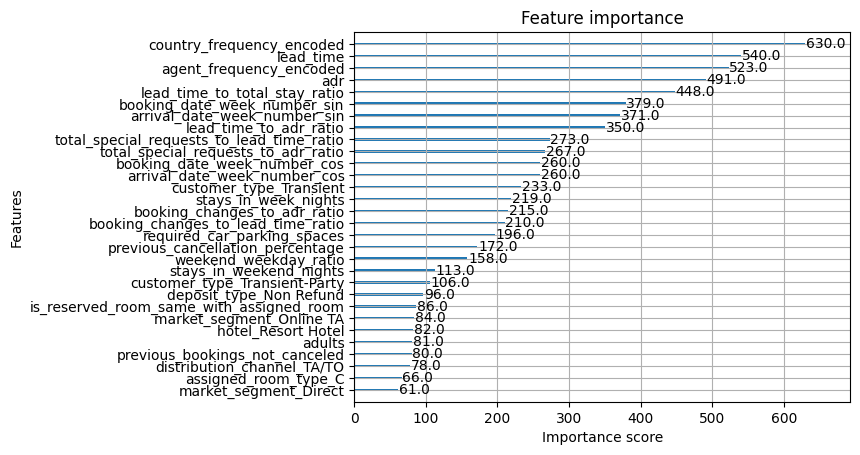

In [26]:
#Weights looks at the number of times feature used in the splits

import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='weight', max_num_features=30)
plt.show()


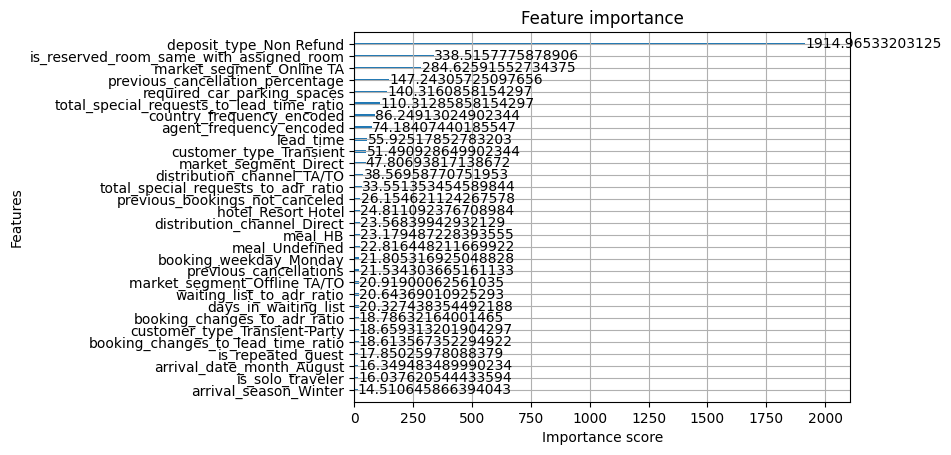

In [27]:
#Gain looks at the avg accuracy gain from splits

import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.show()

 99%|===================| 17758/17907 [01:02<00:00]        


 SHAP Summary Plot (Global Importance)


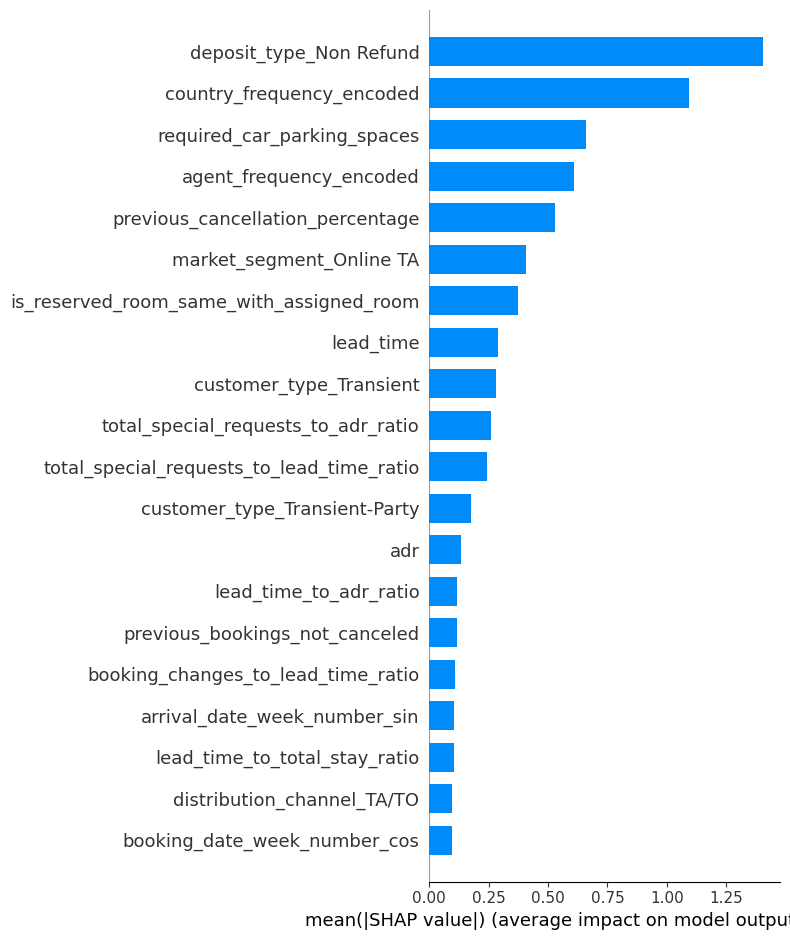


📊 SHAP Beeswarm Plot (Per-sample impact)


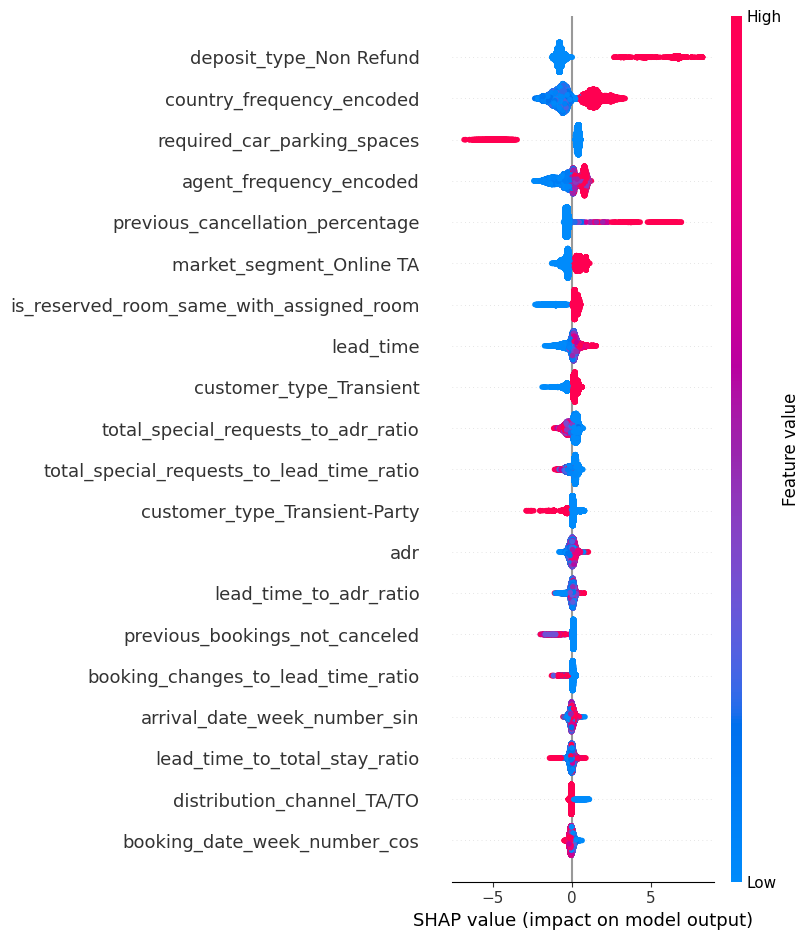

In [28]:
#SHAP Analysis
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_val)

# Calculate SHAP values
shap_values = explainer(X_val)

# Summary plot (global feature importance)
print("\n SHAP Summary Plot (Global Importance)")
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Detailed summary with distribution
print("\n📊 SHAP Beeswarm Plot (Per-sample impact)")
shap.summary_plot(shap_values, X_val)


Interpretation:

- deposit_type_Non Refund is the most influential feature
- Followed by country_frequency_encoded and required_car_parking_spaces
- For deposit_type_Non Refund: high values (red) push predictions to the right -> increasing the chance of cancellation.
- For required_car_parking_spaces: red also pushes right, meaning booking a parking space might increase cancellation risk.

## 5 -Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score

X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

scores = cross_val_score(best_model, X_combined, y_combined, cv=5, scoring='f1')
print("F1 scores from cross-validation:", scores)
print("Mean F1:", scores.mean())


F1 scores from cross-validation: [0.84204082 0.83539679 0.8448135  0.84071038 0.84341589]
Mean F1: 0.8412754768902466


The F1 scores across the 5 different folds are consistent. This indicates that the model is stable and is not overly sensistive to different splits of the data in the CV analysis. 

Validation F1 (0.8518) - is just slightly higher than the cross validated F1
- This may indicate that the model generalizes well and no major signs of overfitting

## 5 - Learning Curves

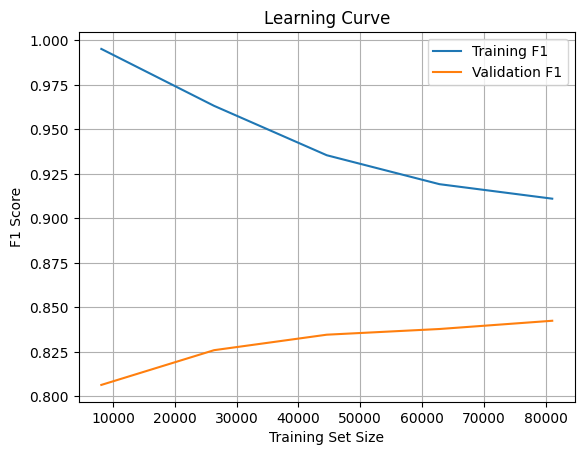

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_combined, y_combined, cv=5, scoring='f1', n_jobs=-1)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training F1')
plt.plot(train_sizes, val_mean, label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Training F1 score 
- Starts off near 1.00 when little data is used (overfitting) and gradually increases with more data
Validation F1 score
- Increases steadily with more training data. More data for the model - it learns general pattern better and performs better on unseen validation folds. 

Verdict from the graph - 
- Model generalises more (less overfitting)
- More data helps for the validation score
- Gap between training and validation score may indicate slight overfitting
- Model is near convergenece but more data may be helpful (don't think this is within our control unless we adjust the splits)

Additional refernce on interpreting Learning Curve:
https://www.dataquest.io/blog/learning-curves-machine-learning/

## Classification Report

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_val, best_model.predict(X_val)))


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     11203
         1.0       0.87      0.84      0.85      6704

    accuracy                           0.89     17907
   macro avg       0.89      0.88      0.88     17907
weighted avg       0.89      0.89      0.89     17907



- Class 0 -> Good performance for the majority class
- Class 1 -> Slightly lower but it can be considered good. Recall can be looked into? (Reducing FN)

### ROC Curve & AUC Score

AUC Score: 0.9587


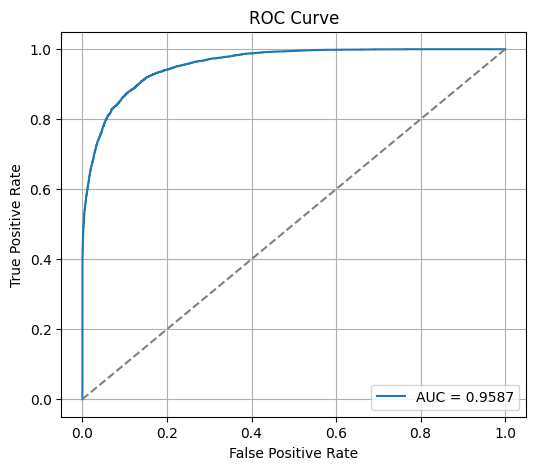

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1 = canceled)
y_probs = best_model.predict_proba(X_val)[:, 1]

# Calculate FP, TP for different thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# AUC score
auc_score = roc_auc_score(y_val, y_probs)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


- Hugs the top left so theres high recall and low false alarm

### PR Curve

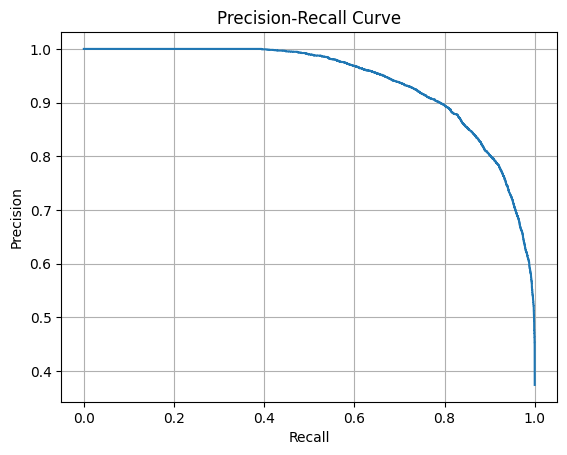

In [33]:
from sklearn.metrics import precision_recall_curve

probs = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


model is able to maintain high precision even as recall increases

## Error Analysis with FP and FN (extra)

In [34]:
# val_df = X_val.copy()
# val_df['true'] = y_val
# val_df['pred'] = best_model.predict(X_val)
# fp = val_df[(val_df['true'] == 0) & (val_df['pred'] == 1)]
# fn = val_df[(val_df['true'] == 1) & (val_df['pred'] == 0)]


In [35]:
# import matplotlib.pyplot as plt

# # Compare distributions of a feature
# feature = 'lead_time'  # experiment with different features

# plt.hist(fp[feature], bins=30, alpha=0.5, label='False Positives')
# plt.hist(fn[feature], bins=30, alpha=0.5, label='False Negatives')
# plt.hist(val_df[val_df['true'] == val_df['pred']][feature], bins=30, alpha=0.5, label='Correct Predictions')
# plt.legend()
# plt.title(f'Distribution of {feature}')
# plt.show()


In [36]:
# import shap

# explainer = shap.Explainer(best_model, X_val)
# shap_values = explainer(X_val)

# # SHAP on false positives
# shap.summary_plot(shap_values[fp.index], X_val.loc[fp.index], plot_type="bar")

# # SHAP on false negatives
# shap.summary_plot(shap_values[fn.index], X_val.loc[fn.index], plot_type="bar")


In [37]:
# fp_mean = fp.drop(columns=['true', 'pred']).mean()
# fn_mean = fn.drop(columns=['true', 'pred']).mean()
# correct = val_df[val_df['true'] == val_df['pred']].drop(columns=['true', 'pred']).mean()

# diff_fp = (fp_mean - correct).sort_values(ascending=False)
# diff_fn = (fn_mean - correct).sort_values(ascending=False)

# print("\n🔍 Top differences (FP vs. Correct):")
# print(diff_fp.head(10))

# print("\n🔍 Top differences (FN vs. Correct):")
# print(diff_fn.head(10))


In [38]:
# y_probs = best_model.predict_proba(X_val)[:, 1]
# val_df['proba_1'] = y_probs

# print("Most confident false positives:")
# print(fp.sort_values(by='proba_1', ascending=False).head())

# print("Most confident false negatives:")
# print(fn.sort_values(by='proba_1').head())


In [39]:
# fn['error_type'] = 'missed positive'
# fp['error_type'] = 'false alarm'

# errors_df = pd.concat([fp, fn])
# errors_df.to_csv("important_model_errors.csv", index=False)


In [40]:
# from sklearn.metrics import f1_score
# import numpy as np

# probs = best_model.predict_proba(X_val)[:, 1]
# thresholds = np.arange(0.1, 0.9, 0.05)

# best_thresh = 0.5
# best_f1 = 0

# for t in thresholds:
#     preds = (probs >= t).astype(int)
#     f1 = f1_score(y_val, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thresh = t

# print(f"Best threshold: {best_thresh:.2f} with F1: {best_f1:.4f}")


In [41]:
# residuals = y_val - best_model.predict(X_val)
# X_val_with_res = X_val.copy()
# X_val_with_res['residual'] = residuals
# print(X_val_with_res.corr()['residual'].sort_values(ascending=False))


## Saving the model

In [42]:
import pickle

# Save the model to a file
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved as 'best_xgb_model.pkl'")


✅ Model saved as 'best_xgb_model.pkl'
